# Sentiment Analysis for WittyWicky Inc.

## Introduction

WittyWicky Inc. is a consulting firm that designs brand strategy for a lot of product startups. Their modus operandi is to gain the pulse of competing products and the associated sentiment from social media. Social media has profound impact in capturing the potential customers and thus there are a lot of consulting firms that operate in the digital strategy space. Whether it is to design a marketing campaign or look at the effect of marketing campaigns on user engagement or sentiment, it is a very valuable tool.

Manual assessment of sentiment is very time consuming and automatic sentiment analysis would deliver a lot of value. As a team of data scientists consulting for WittyWicky Inc., you are now responsible for meeting their business outcomes.

#### Problem Statement
Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

### Dataset Description
This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

#### Evaluation Metric
We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

#### Submission format
Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference.

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
#Display all the columns 
pd.set_option('display.max_columns',None)
# Display full length the column
pd.set_option('display.max_colwidth', -1)


In [72]:
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from nltk.stem.porter import *
from gensim.models import Word2Vec,KeyedVectors
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier


In [3]:
# pip install pyspellchecker

#### Loading Training Data

In [4]:
df_train = pd.read_csv('../../data/train.csv')

#### Loading Test Data

In [5]:
df_test = pd.read_csv('../../data/test.csv')

### Data Analysis

In [6]:
# Basic exploration of train data to check labels
df_train.tail()

,tweet_id,tweet,sentiment
7269,3343,@mention Google plze Tammi. I'm in middle of #SXSW craziness and everything is soooooo busy!,1
7270,5334,RT @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter,1
7271,5378,"RT @mention Aha! Found proof of lactation room, excuse me, &quot;Mother's Room,&quot; brought to you by Google, at last year's #SXSW. {link}",1
7272,2173,We just launched our iPad app at #SXSW! Get all the details + the first edition FREE: {link},1
7273,3162,"The next fin serv battle is vs Apple, GOOG, Mobile operators. They have consumer loyalty and tons of cash (vs. Banks) #bankinnovate #SXSW",1


In [7]:
# Basic exploration of test data to check labels
df_test.tail()

,tweet_id,tweet
1814,1550,@mention @mention @mention Hmmm....how fast can #apple build a new store in time for #sxsw {link}
1815,1933,Samsung Galaxy S II Appears At FCC And Team Android #SXSW Party {link} via @mention
1816,9052,@mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link}
1817,4219,"Wow very long queue of people at apple pop up store now, some have bought 3 iPads! #sxsw@mention Room#NokiaConnects"
1818,7210,Privacy Could Headline Google Circles Social Network Reveal Later Today [Social Networks] {link} #ACLU #GoogleCircles #SXSW


In [11]:
# data types of the features
df_train.dtypes

tweet_id     int64 
tweet        object
sentiment    int64 
dtype: object

In [32]:
# data distribution of target variable
class_count = df_train['sentiment'].value_counts()
class_count

The sentiment labels are:

0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell

#### Bar Plot of value counts

x = np.array(class_count.index)
y = np.array(class_count.values)
plt.figure(figsize=(10,5))
sns.barplot(x,y)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')

# Number of tweets in each Dataset
print('Number of sentences in training set:',len(df_train['tweet_id'].unique()))
print('Number of sentences in test set:',len(df_test['tweet_id'].unique()))
# print('Average words per sentence in train:',df_train.groupby('tweet_id')['sentiment'].count().mean())
# print('Average words per sentence in test:',df_test.groupby('tweet_id')['sentiment'].count().mean())

# Shape of the Datasets
df_train.shape, df_test.shape

#### Using Word Clouds to see the higher fequency words from each sentiment¶


# # stopwords = set(STOPWORDS)
# # def show_wordcloud(data, title = None):
# #     wordcloud = WordCloud(
# #         background_color='black',
# #         stopwords=stopwords,
# #         max_words=10000,
# #         max_font_size=40, 
# #         scale=3,
# #         random_state=1 # chosen at random by flipping a coin; it was heads
# # ).generate(str(data))

# #     fig = plt.figure(1, figsize=(15, 15))
# #     plt.axis('off')
# #     if title: 
# #         fig.suptitle(title, fontsize=20)
# #         fig.subplots_adjust(top=2.3)

# #     plt.imshow(wordcloud)
# #     plt.show()

# # show_wordcloud(df_train['tweet'],'Most Common Words from the whole corpus')

# show_wordcloud(df_train[df_train['sentiment'] == 0]['tweet'],'Negative Tweets')

# # df_train['tweet']
# show_wordcloud(df_train[df_train['sentiment'] == 1]['tweet'],'Neutral Tweets')

# show_wordcloud(df_train[df_train['sentiment'] == 2]['tweet'],'Positive Tweets')

# show_wordcloud(df_train[df_train['sentiment'] == 3]['tweet'],'Can\'t say Tweets')

df_train.iloc[500:600].head()

df_train.isna().sum()

df_train['tweet'].dtype

# df_train['text_length'] = df_train['tweet'].apply(len)
# df_train[['tweet_id','text_length','tweet']].head()

df_train[ df_train['sentiment'] == 0 ].head()

df_train.dropna(inplace=True)

# train_pos = df_train[ df_train['sentiment'] == 2 ]
# train_pos = train_pos['tweet']
# train_neg = df_train[ df_train['sentiment'] == 0]
# train_neg = train_neg['tweet']

# def wordcloud_draw(data, color = 'black'):
#     words = ' '.join(data)
#     cleaned_word = " ".join([word for word in words.split()
#                             if 'http' not in word
#                                 and not word.startswith('@')
#                                 and not word.startswith('#')
#                                 and not word.startswith('{')
#                                 and word != 'RT'
#                                 and word != 'quot'
#                                 and word != 'amp'
#                             ])
#     wordcloud = WordCloud(stopwords=STOPWORDS,
#                       background_color=color,
#                       width=2500,
#                       height=2000
#                      ).generate(cleaned_word)
#     plt.figure(1,figsize=(13, 13))
#     plt.imshow(wordcloud)
#     plt.axis('off')
#     plt.show()
    
# print("Positive tweets")
# # wordcloud_draw(train_pos,'white')
# print("Negative tweets")
# # wordcloud_draw(train_neg)
# print('most common words from the corpus')
# wordcloud_draw(df_train['tweet'])



    

# # pip install plotly==4.7.1

# import plotly.graph_objects as go

# # fig = go.Figure(go.Funnelarea(
# #     text =df_train.sentiment,
# #     values = df_train.tweet,
# #     title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
# #     ))
# # fig.show()

# from collections import Counter

# # df_train['temp_list'] = df_train['tweet'].apply(lambda x:str(x).split())
# # top = Counter([item for sublist in df_train['tweet'] for item in sublist])
# # temp = pd.DataFrame(top.most_common(20))
# # temp.columns = ['Common_words','count']
# # temp.style.background_gradient(cmap='Blues')

# # fig = df_train['tweet'].bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
# #              width=700, height=700,color='Common_words')
# # fig.show()

# # def remove_stopword(x):
# #     return [y for y in x if y not in stopwords.words('english')]
# # df_train['tweet_stopwords'] = df_train['tweet'].apply(lambda x:remove_stopword(x))

# # top = Counter([item for sublist in train['temp_list'] for item in sublist])
# # temp = pd.DataFrame(top.most_common(20))
# # temp = temp.iloc[1:,:]
# # temp.columns = ['Common_words','count']
# # temp.style.background_gradient(cmap='Purples')

# # fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
# # fig.show()

# raw_text = [word for word_list in df_train[['tweet']] for word in word_list]


# def words_unique(sentiments,numwords,raw_words):
#     '''
#     Input:
#         segment - Segment category (ex. 'Neutral');
#         numwords - how many specific words do you want to see in the final result; 
#         raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
#     Output: 
#         dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

#     '''
#     allother = []
#     for item in df_train[df_train.sentiment != sentiments]['tweet']:
#         for word in item:
#             allother .append(word)
#     allother  = list(set(allother ))
    
#     specificnonly = [x for x in raw_text if x not in allother]
    
#     mycounter = Counter()
    
#     for item in df_train[df_train.sentiment == sentiments]['tweet']:
#         for word in item:
#             mycounter[word] += 1
#     keep = list(specificnonly)
    
#     for word in list(mycounter):
#         if word not in keep:
#             del mycounter[word]
    
#     Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
#     return Unique_words

# # Unique_Positive= words_unique(2, 20, raw_text)
# # print("The top 20 unique words in Positive Tweets are:")
# # Unique_Positive.style.background_gradient(cmap='Greens')

1    4311
2    2382
0    456 
3    125 
Name: sentiment, dtype: int64

In [47]:
# # alphanumeric=['' for i in range(7274)]

# # for i in range(7274):
# #     a_string = df_train['tweet'][i]
# #     if type(a_string)!=float:
# #         for character in a_string:
# #             if character.isalnum():
# #                 alphanumeric[i] += character
# #             elif character ==" ":
# #                 alphanumeric[i] +=character
# # alphanumeric

# # df_train.head()

# cdf['tweet'] = alphanumeric

# cdf.head()

# # Creating Tokens
# # tokenized_sents = [word_tokenize(i) for i in alphanumeric]
# # tokenized_sents

# ## Bag of Words

#  - It is a method to extract features from text documents.
#  - These features can be used for training ML algorithms.
#  - It is basically a vocabulary of all unique words occuring in the document in the training dataset.



# # Bow_1 has list of words row wise so like every tweet is converted into a list of words.

# bow_1 = cdf['tweet'].apply(lambda x:word_tokenize(str(x)))
# # print(bow_1.head())

# # Bow_2 has Nested list form of Bow_1 so every list in Bow_1 is combined into one big Nested list.

# bow_2 = []
# for i in bow_1:
#     bow_2.append(i)
# # bow_2

# # Bow_3 has Nested list flattened into a simple list so all the words used in tweets is present in Bow_3 as an element
# # and no nested list present but it has repetition of elements still present.

# bow_3 = []
# def reemovNestings(l): 
#     for i in l: 
#         if type(i) == list: 
#             reemovNestings(i) 
#         else: 
#             bow_3.append(i)
# reemovNestings(bow_2)
# bow_3

# # Bow_final has all unique words of tweets ready to be converted into features for ML Model.

# # bow_final = list(set(bow_3))
# # bow_final

# len(bow_1)

# # bow_1

# # Lemmi
# #initialise word lematizer
# lemmatizer = WordNetLemmatizer()

# for i in range(len(bow_1)):
#     print(lemmatizer.lemmatize(bow_1[i]))


# # cdf['tweet'].head()

# # lemmatizer.lemmatize(cdf['tweet'])

# cdf['tweet'] = [lemmatizer.lemmatize(i[:]) for i in cdf['tweet']]

# df_train['tweet'].head()

# cdf['tweet'].head()

# # type(cdf['tweet'][0])

# # bow_5 = cdf['tweet'].apply(lambda x:lemmatizer.lemmatize(str(x)))

# ps=PorterStemmer()

# cdf['tweet_stem'] =  [ps.stem(i[:]) for i in cdf['tweet']]

# # cdf['tweet_stem']

## Data Preprocessing

In [36]:
# Creating copy of the train dataset
cdf = df_train.copy()

# making tweets to lower case
cdf['tweet']  = cdf['tweet'].str.lower()

# to remove html tags from the tweets using html praser
# Importing HTMLParser
from html.parser import HTMLParser
html = HTMLParser()

# checking for null values
cdf['tweet'].isna().sum()

# droping the single null value present in the train dataset
cdf.dropna(inplace=True)

# Created a new columns i.e. tweet_html which do not contain html tags
cdf['tweet_html'] = cdf['tweet'].apply(lambda x: html.unescape(x))
print(cdf.head(10))

type(cdf['tweet_html'])

   tweet_id  \
0  1701       
1  1851       
2  2689       
3  4525       
4  3604       
5  966        
6  1395       
7  8182       
8  8835       
9  883        

                                                                                                                                             tweet  \
0  #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                         
1  learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw   
2  one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot;  {link}              
3  this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork                     
4  line outside the apple store in austin waiting for the new ipad #sxsw  {link}    

pandas.core.series.Series

In [39]:
cdf.shape

(7273, 4)

In [51]:
cdf['tweet_html'].head()

0    #sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller                                                  
1    learning ab google doodles! all doodles should be light, funny & innovative, with exceptions for significant occasions. #googledoodle #sxsw
2    one of the most in-your-face ex. of stealing the show in yrs rt @mention "at #sxsw, apple schools the mkt experts"  {link}                 
3    this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork              
4    line outside the apple store in austin waiting for the new ipad #sxsw  {link}                                                              
Name: tweet_html, dtype: object

In [52]:
# Adding unnecessary char to stop words
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't"]

# creating tokens
cdf['tweet_tokens'] = [nltk.word_tokenize(x) for x in cdf['tweet_html']]

# Removing stop words 
cdf['tweet_tokens'] = cdf['tweet_tokens'].apply(lambda row: [word for word in row if word not in stop_words])

#Applying the stemming

# stemmer = PorterStemmer()
# cdf['tweet_tokens'] = cdf['tweet_tokens'].apply(lambda x: [stemmer.stem(i) for i in x])
# cdf['tokenized_tweet'] = cdf['tweet_tokens'].apply(lambda x: ' '.join(x))
# cdf.head()

#Applying the lemmatizer

lemma = WordNetLemmatizer()
cdf['tweet_tokens'] = cdf['tweet_tokens'].apply(lambda x: [lemma.lemmatize(i) for i in x])
cdf['tweet_tokens'] = cdf['tweet_tokens'].apply(lambda x: ' '.join(x))
cdf.head()

,tweet_id,tweet,sentiment,tweet_html,tweet_tokens
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,sxswnui sxsw apple defining language touch different dialect becoming smaller
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,"learning ab google doodles! all doodles should be light, funny & innovative, with exceptions for significant occasions. #googledoodle #sxsw",learning ab google doodle doodle light funny innovative exception significant occasion googledoodle sxsw
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2,"one of the most in-your-face ex. of stealing the show in yrs rt @mention ""at #sxsw, apple schools the mkt experts"" {link}",one in-your-face ex stealing show yr rt mention sxsw apple school mkt expert '' link
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,iphone sxsw app would b pretty awesome crash every 10mins extended browsing fuckit illmakeitwork
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1,line outside the apple store in austin waiting for the new ipad #sxsw {link},line outside apple store austin waiting new ipad sxsw link


## Features Extraction

In [62]:
def feature_extraction(data, method = "tfidf"):
    #arguments: data = all the tweets in the form of array, method = type of feature extracter
    #methods of feature extractions: "tfidf" and "doc2vec"
    if method == "tfidf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfv=TfidfVectorizer(sublinear_tf=True) # we need to give proper stopwords list for better performance
        features=tfv.fit_transform(data)
        
    else:
        return "Incorrect inputs"
return features

In [109]:
vector = feature_extraction(cdf['tweet_tokens'],method='tfidf')

In [110]:
initial_tfidf = vector.toarray()

In [112]:
initial_tfidf.shape

(7273, 8184)

In [113]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(initial_tfidf,cdf['sentiment'],test_size=0.4,random_state=42)

#Initialising the logistic regression model
log_reg = LogisticRegression(random_state=42)

#Fitting the model with train data
log_reg.fit(X_train,y_train)

#Finding the accuracy score of model on test data
acc = log_reg.score(X_test,y_test)
log_predict = log_reg.predict(X_test)
f1 = f1_score(log_predict,y_test,average='weighted')

print ("Accuracy Score: ", acc)
print('f1 score:', f1)

Accuracy Score:  0.6769759450171822
f1 score: 0.717694696068809


In [94]:
from sklearn.metrics import f1_score ,roc_auc_score
from sklearn.naive_bayes import MultinomialNB


In [96]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)
nb_acc = nb.score(X_test,y_test)
f1 = f1_score(y_pred,y_test,average='weighted')

print ("Accuracy Score: ", nb_acc)
print('f1 score:', f1)

Accuracy Score:  0.6405498281786941
f1 score: 0.7246448772268967


In [92]:
# def train_classifier(features, label, classifier = "logistic_regression"):
#     #arguments: features = output of feature_extraction(...), label = labels in array form, classifier = type of classifier 
# #     from sklearn.metrics import roc_auc_score # we will use auc as the evaluation metric
#     if classifier == "logistic_regression": # auc (train data): 0.8780618441250002
#         from sklearn.linear_model import LogisticRegression
#         model = LogisticRegression(C=1.)
#     elif classifier == "naive_bayes": # auc (train data): 0.8767891829687501
#         from sklearn.naive_bayes import MultinomialNB
#         model = MultinomialNB()
#     elif classifier == "svm": # can't use sklearn svm, as way too much of data so way to slow. have to use tensorflow for svm
#         from sklearn.svm import SVC
#         model = SVC()
#     else:
#         print("Incorrect selection of classifier")
#     #fit model to data
#     model.fit(features, label)
#     #make prediction on the same (train) data
#     probability_to_be_positive = model.predict_proba(features)[:,1]
#     #chcek AUC(Area Undet the Roc Curve) to see how well the score discriminates between negative and positive
#     print ("auc (train data):" , roc_auc_score(label, probability_to_be_positive))
#     #print top 10 scores as a sanity check
#     print ("top 10 scores: ", probability_to_be_positive[:10])
#     #print f1 score 
#     label_pred = model.predict(X_test)
#     print('f1 score: ',f1_score(label_pred,label,average='weighted'))

In [93]:
# train_classifier(features=X_train,label=y_train,classifier='naive_bayes')

In [97]:
def get_hashtags(text, handle_space=True):

    if handle_space:
        space = r"#\s+"
        text = re.sub(space, "#", str(text).lower()).strip()
    
    hash_tags = r"#\S+"
    
    return " ".join(re.findall(hash_tags, text))

In [98]:
cdf['hashtags'] = df_train.tweet.apply(get_hashtags)

In [100]:
# cdf

,tweet_id,tweet,sentiment,tweet_html,tweet_tokens,hashtags
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,sxswnui sxsw apple defining language touch different dialect becoming smaller,#sxswnui #sxsw #apple
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,"learning ab google doodles! all doodles should be light, funny & innovative, with exceptions for significant occasions. #googledoodle #sxsw",learning ab google doodle doodle light funny innovative exception significant occasion googledoodle sxsw,#googledoodle #sxsw
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2,"one of the most in-your-face ex. of stealing the show in yrs rt @mention ""at #sxsw, apple schools the mkt experts"" {link}",one in-your-face ex stealing show yr rt mention sxsw apple school mkt expert '' link,"#sxsw,"
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,iphone sxsw app would b pretty awesome crash every 10mins extended browsing fuckit illmakeitwork,#sxsw #fuckit #illmakeitwork
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1,line outside the apple store in austin waiting for the new ipad #sxsw {link},line outside apple store austin waiting new ipad sxsw link,#sxsw
5,966,#technews one lone dude awaits ipad 2 at appleûªs sxsw store {link} #tech_news #apple #ipad_2 #sxsw #tablets #tech,1,#technews one lone dude awaits ipad 2 at appleûªs sxsw store {link} #tech_news #apple #ipad_2 #sxsw #tablets #tech,technews one lone dude awaits ipad 2 appleûªs sxsw store link tech_news apple ipad_2 sxsw tablet tech,#technews #tech_news #apple #ipad_2 #sxsw #tablets #tech
6,1395,"sxsw tips, prince, npr videos, toy shopping with zuckerberg.\r\n{link} #sxsw #ipad",1,"sxsw tips, prince, npr videos, toy shopping with zuckerberg.\r\n{link} #sxsw #ipad",sxsw tip prince npr video toy shopping zuckerberg link sxsw ipad,#sxsw #ipad
7,8182,nu user rt @mention new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable,1,nu user rt @mention new #ubersocial for #iphone now in the app store includes uberguide to #sxsw sponsored by #mashable,nu user rt mention new ubersocial iphone app store includes uberguide sxsw sponsored mashable,#ubersocial #iphone #sxsw #mashable
8,8835,free #sxsw sampler on itunes {link} #freemusic,2,free #sxsw sampler on itunes {link} #freemusic,free sxsw sampler itunes link freemusic,#sxsw #freemusic
9,883,i think i might go all weekend without seeing the same ipad case twice... #sxsw,2,i think i might go all weekend without seeing the same ipad case twice... #sxsw,think might go weekend without seeing ipad case twice sxsw,#sxsw


In [23]:
df_train['hashtags'].head()

0    #sxswnui #sxsw #apple       
1    #googledoodle #sxsw         
2    #sxsw,                      
3    #sxsw #fuckit #illmakeitwork
4    #sxsw                       
Name: hashtags, dtype: object

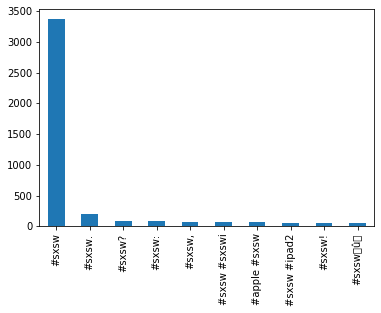

In [24]:
df_train['hashtags'].value_counts().head(10).plot(kind='bar')

In [25]:
# hash = df_train['tweet'].str.extractall(r"(#\S+)")

In [26]:
# hash

In [114]:
cdf.head()

,tweet_id,tweet,sentiment,tweet_html,tweet_tokens,hashtags
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,sxswnui sxsw apple defining language touch different dialect becoming smaller,#sxswnui #sxsw #apple
1,1851,"learning ab google doodles! all doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #googledoodle #sxsw",1,"learning ab google doodles! all doodles should be light, funny & innovative, with exceptions for significant occasions. #googledoodle #sxsw",learning ab google doodle doodle light funny innovative exception significant occasion googledoodle sxsw,#googledoodle #sxsw
2,2689,"one of the most in-your-face ex. of stealing the show in yrs rt @mention &quot;at #sxsw, apple schools the mkt experts&quot; {link}",2,"one of the most in-your-face ex. of stealing the show in yrs rt @mention ""at #sxsw, apple schools the mkt experts"" {link}",one in-your-face ex stealing show yr rt mention sxsw apple school mkt expert '' link,"#sxsw,"
3,4525,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,0,this iphone #sxsw app would b pretty awesome if it didn't crash every 10mins during extended browsing. #fuckit #illmakeitwork,iphone sxsw app would b pretty awesome crash every 10mins extended browsing fuckit illmakeitwork,#sxsw #fuckit #illmakeitwork
4,3604,line outside the apple store in austin waiting for the new ipad #sxsw {link},1,line outside the apple store in austin waiting for the new ipad #sxsw {link},line outside apple store austin waiting new ipad sxsw link,#sxsw


In [116]:
cdf.to_csv(r'C:\Users\Vardhaman\Desktop\DS\Hackathon_3\git_sentiment\data\Iter\train_clean_data.csv', index = False)

In [ ]:
cdf.to_csv(r'C:\Users\Vardhaman\Desktop\DS\Hackathon_3\git_sentiment\data\Iter\train_clean_data.csv', index = False)